# Learning the Lennard-Jones (LJ) Potential
This notebook demonstrates how to learn a **pair potential** (e.g., Lennard-Jones) from Molecular Dynamics (MD) simulations by optimizing against **Radial Distribution Functions (RDFs)** and **Velocity Auto-Correlation Functions (VACFs)**.

### **Key Concepts**
- **Lennard-Jones Potential**: Describes interactions between two particles:

$$
  U(r) = 4 \varepsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right] 

  $$
- **MD Simulations**: Use **Nose-Hoover Chain thermostat** to evolve the system.
- **Objective**: Learn a potential function that reproduces the RDF and VACF of a reference system.


## Importing Required Libraries

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.lattice.cubic import FaceCenteredCubic, Diamond

from ase.visualize import *
from data_src.data import *
from potential_src.pairMLP.potential_PairMLP import *
from observables.rdf import *
from observables.observers import *   
from utils.get_utils import *

def plot_vacf(vacf_sim, vacf_target, fn, path, dt=0.01, save_data=False):

    t_range = np.linspace(0.0,  vacf_sim.shape[0], vacf_sim.shape[0]) * dt 

    plt.plot(t_range, vacf_sim, label='simulation', linewidth=4, alpha=0.6, )

    if vacf_target is not None:
        plt.plot(t_range, vacf_target, label='target', linewidth=2,linestyle='--', c='black' )

    plt.legend()
    plt.show()

    if save_data:
         np.savetxt(path + '/vacf_{}.txt'.format(fn), np.stack((t_range, vacf_sim)), delimiter=',' )
         np.savetxt(path + '/vacf_{}_target.txt'.format(fn), np.stack((t_range, vacf_target)), delimiter=',' )

    plt.savefig(path + '/vacf_{}.pdf'.format(fn), bbox_inches='tight')
    plt.close()

def plot_rdf( g_sim, rdf_target, fn, path, start, nbins, save_data=False, end=2.5):

    bins = np.linspace(start, end, nbins)

    plt.plot(bins, g_sim , label='simulation', linewidth=4, alpha=0.6)
    plt.plot(bins, rdf_target , label='target', linewidth=2,linestyle='--', c='black')
    
    plt.xlabel("$\AA$")
    plt.ylabel("g(r)")

    if save_data:
        np.savetxt(path + '/rdf_{}.txt'.format(fn), np.stack((bins, g_sim)), delimiter=',' )
        np.savetxt(path + '/rdf_{}_target.txt'.format(fn), np.stack((bins, rdf_target)), delimiter=',' )

    plt.show()
    plt.savefig(path + '/rdf_{}.pdf'.format(fn), bbox_inches='tight')
    plt.close()

def plot_pair(fn, path, model, prior, device, end=2.5, target_pot=None): 

    if target_pot is None:
        target_pot = LennardJones(1.0, 1.0)
    else:
        target_pot = target_pot.to("cpu")

    x = torch.linspace(0.1, end, 250)[:, None].to(device)
    
    u_fit = (model(x) + prior(x)).detach().cpu().numpy()
    u_fit = u_fit - u_fit[-1] 

    u_target = target_pot(x.detach().cpu()).squeeze()

    plt.plot( x.detach().cpu().numpy(), 
              u_fit, 
              label='fit', linewidth=4, alpha=0.6)
    
    plt.plot( x.detach().cpu().numpy(), 
              u_target.detach().cpu().numpy(),
               label='truth', 
               linewidth=2,linestyle='--', c='black')

    plt.ylim(-2, 4.0)
    plt.legend()      
    plt.show()
    plt.savefig(path + '/potential_{}.jpg'.format(fn), bbox_inches='tight')
    plt.close()

    return u_fit


# System Definition
We first define the **simulation parameters**, such as density, temperature, and the cutoff radius.
We also initialize the **MD system** using ASE (Atomic Simulation Environment).

In [2]:
pair_data_dict = {  'lj_0.3_1.2': {
            'rdf_fn': '../data/LJ_data/rdf_rho0.3_T1.2_dt0.01.csv' ,
            'vacf_fn': '../data/LJ_data/vacf_rho0.3_T1.2_dt0.01.csv' ,
            'rho': 0.3,
            'T': 1.2, 
            'start': 0.75, 
            'end': 3.3,
            'element': "H",
            'mass': 1.0,
            "N_unitcell": 4,
            "cell": FaceCenteredCubic,
            "target_pot": LennardJones()
            },

             'lj_0.5_1.2': {
            'rdf_fn': '../data/LJ_data/rdf_rho0.5_T1.2_dt0.01.csv' ,
            'vacf_fn': '../data/LJ_data/vacf_rho0.5_T1.2_dt0.01.csv' ,
            'rho': 0.5,
            'T': 1.2, 
            'start': 0.75, 
            'end': 3.3,
            'element': "H",
            'mass': 1.0,
            "N_unitcell": 4,
            "cell": FaceCenteredCubic,
            "target_pot": LennardJones()
            }, 
            
    'lj_0.7_1.2': {
                'rho': 0.7,
                'T': 1.2, 
                'start': 0.75, 
                'end': 3.3,
                'element': "H",
                'mass': 1.0,
                "N_unitcell": 4,
                "cell": FaceCenteredCubic,
                "target_pot": LennardJones()
                },

  }

width_dict = {'tiny': 64,
               'low': 128,
               'mid': 256, 
               'high': 512}

gaussian_dict = {'tiny': 16,
               'low': 32,
               'mid': 64, 
               'high': 128}


The simulation in this code is self-consistent, meaning all computations are handled within the script without relying on external molecular dynamics software like LAMMPS or GROMACS. Everything—potential evaluation, numerical integration, observables extraction, and model training—is done internally using PyTorch, ASE, and custom simulation modules.

The function 'get_system()' initializes a periodic atomic system in 3D using ASE.
We need to define:
- density
- temperature
- lattice type (e.g. FCC)
- PBCs


In [3]:
def get_system(data_str, device, size):
    # here we define an NVT system setup
    rho = pair_data_dict[data_str]['rho']
    T = pair_data_dict[data_str]['T']
    dim = pair_data_dict[data_str].get("dim", 3)

    if dim == 3:
        # initialize states with ASE 
        cell_module = pair_data_dict[data_str]['cell']
        N_unitcell = pair_data_dict[data_str]['N_unitcell']
        def get_unit_len(rho, N_unitcell):
            L = (N_unitcell / rho) ** (1/3)
            return L 
        L = get_unit_len(rho, N_unitcell)
        print("lattice param:", L)
        atoms = cell_module(symbol=pair_data_dict[data_str]['element'],
                                  size=(size, size, size),
                                  latticeconstant= L,
                                  pbc=True)
        system = System(atoms, device=device)
        system.set_temperature(T)

    return system 

The system uses a ground truth potential (target_pot) from pair_data_dict.
This potential can be:
-Lennard-Jones (LJ) for simple atomic interactions.
-Custom pair potentials for more complex interactions.
This potential is implemented in PyTorch, meaning forces and energies are computed dynamically without external MD engines.


The function get_target_obs() sets up and runs the simulation.


In [4]:
def get_target_obs(system, data_str, n_sim, rdf_range, nbins, t_range, dt, skip=25):
    print("simulating {}".format(data_str))
    device = system.device 
    # simulation setup
    target_pot = pair_data_dict[data_str]['target_pot'] # take target potential
    T = pair_data_dict[data_str]['T'] # take target temperature

    pot = PairPotentials(system, target_pot, cutoff=2.5, nbr_list_device=device).to(device)

    diffeq = NoseHooverChain(pot, 
            system,
            Q=50.0, 
            T=T,
            num_chains=5, 
            adjoint=True,
            topology_update_freq=1).to(system.device)

    # define simulator with 
    sim = Simulations(system, diffeq)

    # define objects for the observables
    rdf_obs = rdf(system, nbins=nbins, r_range=rdf_range)
    vacf_obs = vacf(system, t_range=t_range) 
    
    all_vacf_sim = []

    # Run MD Simulations & Extract Target Data
    for i in range(n_sim):
        v_t, q_t, pv_t = sim.simulate(100, dt=dt, frequency=100) # 100 time steps, dt is given with argparse are in fs, freq is how often the system's state is updated and logged during a md simulation.

        if i >= skip:
            vacf_sim = vacf_obs(v_t).detach().cpu().numpy()
            all_vacf_sim.append(vacf_sim)
            
    # loop over to compute observables 
    trajs = torch.Tensor( np.stack( sim.log['positions'])).to(system.device).detach()
    all_g_sim = []
    for i in range(len(trajs)):

        if i >= skip:
            _, _, g_sim = rdf_obs(trajs[[i]])
            all_g_sim.append(g_sim.detach().cpu().numpy())

    all_g_sim = np.array(all_g_sim).mean(0)
    all_vacf_sim = np.array(all_vacf_sim).mean(0)
    
    return all_g_sim, all_vacf_sim


In [5]:
def get_observer(system, data_str, nbins, t_range, rdf_start):
    # get dt 
    dt = pair_data_dict[data_str].get('dt', 0.01)

    rdf_end = pair_data_dict[data_str].get("end", None)

    xnew = np.linspace(rdf_start , rdf_end, nbins)
    
    # initialize observable function 
    obs = rdf(system, nbins, (rdf_start , rdf_end) )
    vacf_obs = vacf(system, t_range=t_range) 

    # get experimental rdf 
    dim = pair_data_dict[data_str].get("dim", 3) 

    rdf_data_path = pair_data_dict[data_str].get("fn", None)
    # generate simulated data 
    if not rdf_data_path:
        rdf_data, vacf_target = get_target_obs(system, data_str, 200, (rdf_start, rdf_end), nbins=nbins, t_range=t_range, skip=50, dt=dt)
        vacf_target = torch.Tensor(vacf_target).to(system.device)
        rdf_data = np.vstack( (np.linspace(rdf_start, rdf_end, nbins), rdf_data))
    else:
        # experimental rdfs
        rdf_data = np.loadtxt(rdf_data_path, delimiter=',')
        vacf_target = None

    _, rdf_target = get_exp_rdf(rdf_data, nbins, (rdf_start, rdf_end), obs.device, dim=dim)

    # get model potential and simulate 

    return xnew, rdf_target, obs, vacf_target, vacf_obs

In [6]:
def get_sim(system, model, data_str, topology_update_freq=1):

    T = pair_data_dict[data_str]['T']

    diffeq = NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=T,
            num_chains=5, 
            adjoint=True,
            topology_update_freq=topology_update_freq).to(system.device)

    # define simulator with 
    sim = Simulations(system, diffeq)

    return sim

## Define Training Hyperparameters

 – Set learning rate, epochs, and training options.

In [27]:
params = {
    'val': ['lj_0.5_1.2','lj_0.7_1.2']
}
sys_params = {
    'val': params['val'],
}

In [28]:
n_epochs = 1000
n_sim = 200
size = 4
cutoff = 2.5
t_range = 50
device = 'cpu'

nbins = 100
tau = 60 #assignments['opt_freq']

rdf_start = 0.75
skip = 1

nbr_list_device = 'cpu'
topology_update_freq = 1

data_str_list = ['lj_0.3_1.2']

# Get the grounth truth pair potentials
target_pot = LennardJones()

# merge paramset a
if sys_params['val']:
    val_str_list = sys_params['val']
else:
    val_str_list = []

project_name = 'lj_sim'
suggestion_id = 'run0'
model_path = '{}/{}'.format(project_name, suggestion_id)
if not os.path.exists(model_path):
    os.makedirs(model_path)

print("Training for {} epochs".format(n_epochs))

train_vacf = True

Training for 1000 epochs


## Initialize the MD System 
– Set up atoms, boundary conditions, and simulation parameters

In [29]:
system_list = []
for data_str in data_str_list+val_str_list:
    system = get_system(data_str, device, size) 
    system_list.append(system)

lattice param: 2.371262202993375
lattice param: 2.0
lattice param: 1.7878070701931352


/Users/francescapagano/miniconda3/envs/myenv_mlmd/lib/python3.9/site-packages/ase/md/md.py:52: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


### what is system ? 
System is the starting point for the simulation:

In [32]:
from ase.visualize import view
view(system_list[2])

<Popen: returncode: None args: ['/Users/francescapagano/miniconda3/envs/myen...>

2025-01-31 16:36:57.376 python[20327:5287247] +[IMKClient subclass]: chose IMKClient_Legacy
2025-01-31 16:36:57.376 python[20327:5287247] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


## Potential
- LJ potential is the physics-informed prior potential 
- The neural network model (pairMLP) learns corrections to the prior potential

In [11]:
class LJFamily(torch.nn.Module):
    def __init__(self, sigma=1.0, epsilon=1.0, attr_pow=6,  rep_pow=12):
        super(LJFamily, self).__init__()
        self.sigma = torch.nn.Parameter(torch.Tensor([sigma]))
        self.epsilon = torch.nn.Parameter(torch.Tensor([epsilon]))
        self.attr_pow = attr_pow
        self.rep_pow = rep_pow 

    def LJ(self, r, sigma, epsilon):
        return 4 * epsilon * ((sigma/r)**self.rep_pow - (sigma/r)**self.attr_pow)

    def forward(self, x):
        return self.LJ(x, self.sigma, self.epsilon)

mlp_parmas = {'n_gauss': int(cutoff//0.10), # cutoff//gaussian_width 
            'r_start': 0.0,
            'r_end': cutoff, 
            'n_width': 128,
            'n_layers': 3,
            'nonlinear': 'ELU'}
lj_params = {'epsilon': 0.4, 
             'sigma': 0.9,
             "power": 10}

NN = pairMLP(**mlp_parmas)
pair = LJFamily(epsilon=2.0, sigma=0.9, rep_pow=6, attr_pow=3)  # ExcludedVolume(**lj_params)

model_list = []
for i, data_str in enumerate(data_str_list + val_str_list):

    pairNN = PairPotentials(system_list[i], NN,
                cutoff=cutoff,
                nbr_list_device=nbr_list_device
                ).to(device)
    prior = PairPotentials(system_list[i], pair,
                    cutoff=2.5,
                nbr_list_device=nbr_list_device
                    ).to(device)

    model = Stack({'pairnn': pairNN, 'pair': prior})
    model_list.append(model)

/Users/francescapagano/mdgrad_mini/srcLJ/potential_src/pairMLP/interface.py:69: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  self.cell = torch.Tensor(system.get_cell()).to(system.device)


Stack combines:
- A learned NN potential (pairnn)
- A predefined Lennard-Jones potential (pair)
The model will sum the outputs of pairnn and pair to compute the total energy.


### Data Flow 

Atomic Positions → Compute Pairwise Distances (r_ij) →  
│  
├──> Lennard-Jones Potential (pair) → U_LJ(r_ij)  
│  
├──> Neural Network Potential (pairnn)  
│       ├── GaussianSmearing(r_ij)  
│       ├── Feedforward NN (Linear + ELU Layers)  
│       └── Output: U_MLP(r_ij)  
│  
└──> Final Potential: U_total = U_LJ + U_MLP → Sum Over Pairs → Compute System Energy  
      │  
      └──> Use for Molecular Dynamics (Forces, Simulations, Training)  


In [12]:
def print_model_summary(model):
    print("Model Structure:")
    print("---------------")
    for name, submodel in model.models.items():
        print(f"\n{name}:")
        print("  Network architecture:")
        for child_name, child in submodel.named_children():
            print(f"    {child_name}: {child}")
        
        if hasattr(submodel, 'model'):
            print("\n  Potential network:")
            for layer_name, layer in submodel.model.named_children():
                print(f"    {layer_name}: {layer}")

# Use it on your model
print_model_summary(model)

Model Structure:
---------------

pairnn:
  Network architecture:
    model: pairMLP(
  (smear): GaussianSmearing()
  (layers): ModuleList(
    (0): Linear(in_features=24, out_features=24, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=24, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=24, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=24, out_features=1, bias=True)
  )
)

  Potential network:
    smear: GaussianSmearing()
    layers: ModuleList(
  (0): Linear(in_features=24, out_features=24, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=24, out_features=128, bias=True)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=128, out_features

In [13]:
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
        print(f"{name}: {list(param.shape)} ({param_count} parameters)")
    print(f"\nTotal parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

count_parameters(model)

models.pairnn.model.smear.width: [24] (24 parameters)
models.pairnn.model.smear.offsets: [24] (24 parameters)
models.pairnn.model.layers.0.weight: [24, 24] (576 parameters)
models.pairnn.model.layers.0.bias: [24] (24 parameters)
models.pairnn.model.layers.2.weight: [128, 24] (3072 parameters)
models.pairnn.model.layers.2.bias: [128] (128 parameters)
models.pairnn.model.layers.4.weight: [128, 128] (16384 parameters)
models.pairnn.model.layers.4.bias: [128] (128 parameters)
models.pairnn.model.layers.6.weight: [128, 128] (16384 parameters)
models.pairnn.model.layers.6.bias: [128] (128 parameters)
models.pairnn.model.layers.8.weight: [128, 128] (16384 parameters)
models.pairnn.model.layers.8.bias: [128] (128 parameters)
models.pairnn.model.layers.10.weight: [24, 128] (3072 parameters)
models.pairnn.model.layers.10.bias: [24] (24 parameters)
models.pairnn.model.layers.12.weight: [1, 24] (24 parameters)
models.pairnn.model.layers.12.bias: [1] (1 parameters)
models.pair.model.sigma: [1] (1 p

In [14]:
sim_list = [get_sim(system_list[i], 
                    model_list[i], 
                    data_str,
                    topology_update_freq=topology_update_freq) for i, data_str in enumerate(data_str_list + val_str_list)]
sim_list

This cell initializes and collects observables for each molecular system in data_str_list + val_str_list.
The goal is to compute and store Radial Distribution Function (RDF) and Velocity Auto-Correlation Function (VACF), both for sim and target.

In [15]:
rdf_obs_list = [] #Stores functions to compute RDF during training.
vacf_obs_list = [] #Stores functions to compute VACF during training

rdf_target_list = [] #Stores ground truth RDF data for comparison.
vacf_target_list = [] #Stores ground truth VACF data for comparison.
rdf_bins_list = [] #Stores distance bins for RDF computation

for i, data_str in enumerate(data_str_list + val_str_list):
    rdf_start = pair_data_dict[data_str].get("start", 0.75)
    x, rdf_target, rdf_obs, vacf_target, vacf_obs = get_observer(system_list[i],
                                                                    data_str, 
                                                                    nbins, 
                                                                    t_range=t_range,
                                                                    rdf_start=rdf_start)
    rdf_bins_list.append(x)

    rdf_obs_list.append(rdf_obs)
    rdf_target_list.append(rdf_target)
    vacf_obs_list.append(vacf_obs)
    vacf_target_list.append(vacf_target)


simulating lj_0.3_1.2
simulating lj_0.5_1.2
simulating lj_0.7_1.2


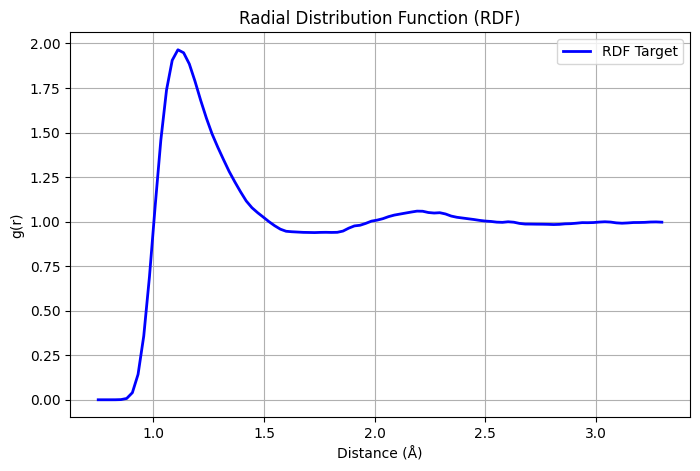

In [16]:
import torch
import matplotlib.pyplot as plt

# Convert tensor to NumPy array
rdf_target = rdf_target_list[0].cpu().numpy()  # Assuming first entry is needed
plt.figure(figsize=(8, 5))
plt.plot(rdf_bins_list[0], rdf_target, label="RDF Target", color='b', linewidth=2)

plt.xlabel("Distance (Å)")
plt.ylabel("g(r)")
plt.title("Radial Distribution Function (RDF)")
plt.legend()
plt.grid()
plt.show()


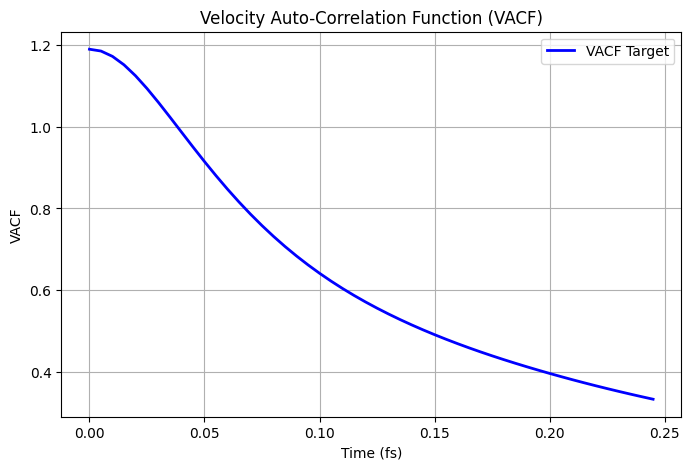

In [25]:
import torch
import matplotlib.pyplot as plt
time_bins = torch.arange(len(vacf_target)).cpu().numpy() * 0.005  # Assuming dt is known

# Convert tensor to NumPy array
vacf_target = vacf_target_list[0].cpu().numpy()  # Assuming first entry is needed
plt.figure(figsize=(8, 5))
plt.plot(time_bins,vacf_target, label="VACF Target", color='b', linewidth=2)


plt.xlabel("Time (fs)")
plt.ylabel("VACF")
plt.title("Velocity Auto-Correlation Function (VACF)")
plt.legend()
plt.grid()
plt.show()


## Initialize Training Components

In [18]:
optimizer = torch.optim.Adam(list(NN.parameters()), lr=0.002)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                'min', 
                                                min_lr=1e-6, 
                                                verbose=True, factor = 0.5, patience= 20,
                                                threshold=5e-5)

# Set up simulations 
loss_log = []

# 
obs_log = dict()



/Users/francescapagano/miniconda3/envs/myenv_mlmd/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Precompute Observables for Training

In [19]:
for i, data_str in enumerate(data_str_list + val_str_list):
    obs_log[data_str] = {}
    obs_log[data_str]['rdf'] = []
    obs_log[data_str]['vacf'] = []

## Training

In [20]:
rdf_weight = 0.95
vacf_weight = 0.0
n_epochs = 20

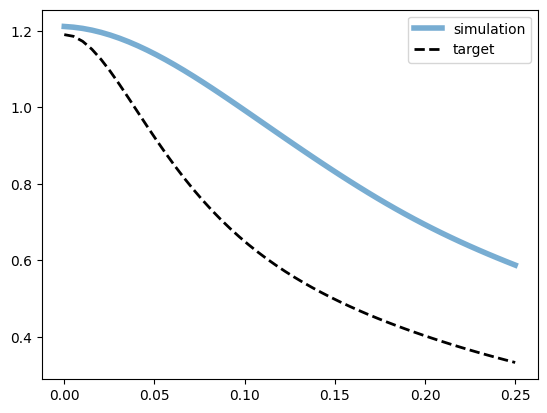

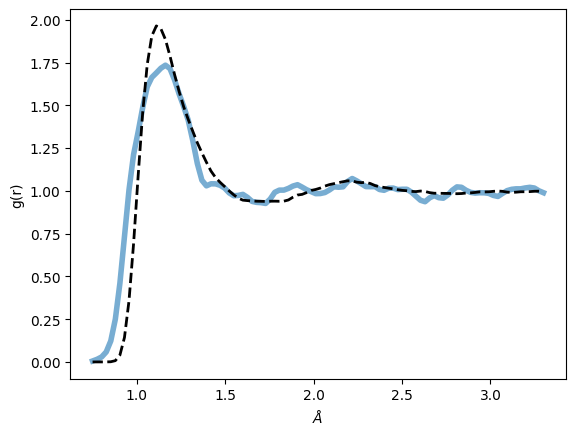

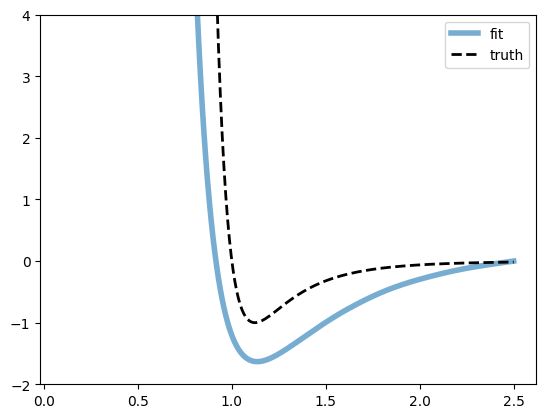

0.07782364636659622 0.017195293679833412
0.12100525200366974 0.04295526444911957
0.09678277373313904 0.07270179688930511
0.07538194209337234 0.07552662491798401
0.04776054993271828 0.05726686492562294


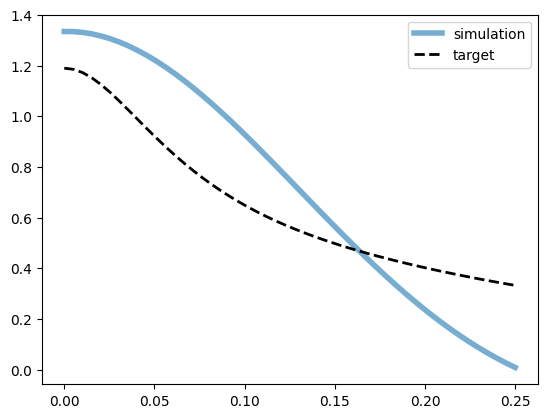

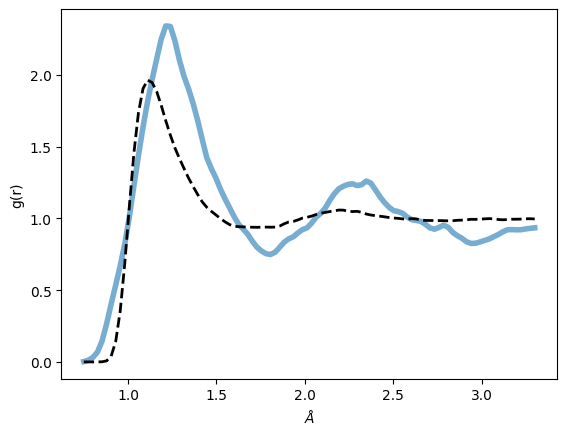

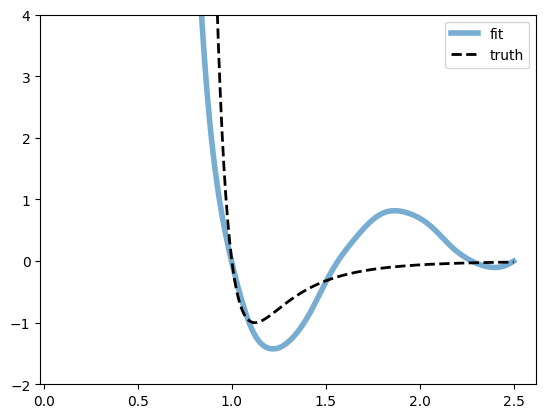

0.05163290351629257 0.05890334025025368
0.050727758556604385 0.09023872017860413
0.015702534466981888 0.08856239914894104
0.024526014924049377 0.05331363528966904
0.06083633378148079 0.019221283495426178


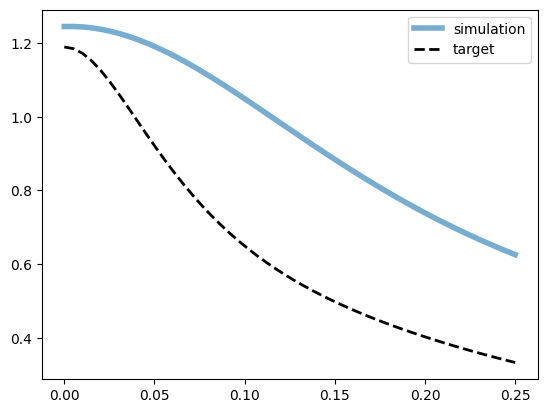

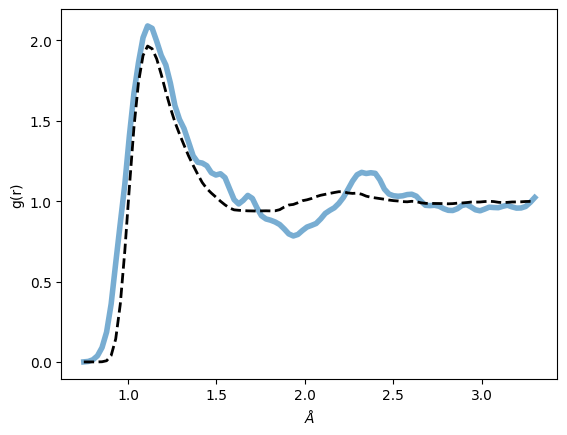

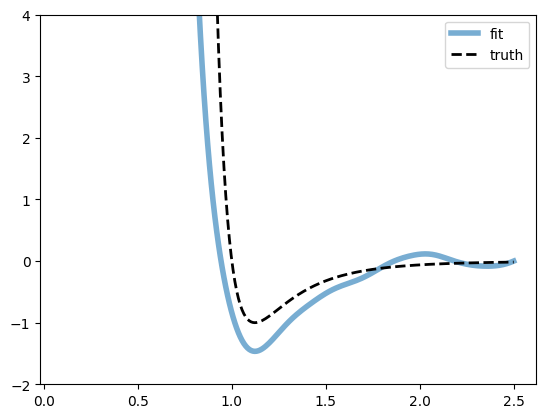

0.10687059164047241 0.017765646800398827
0.07949746400117874 0.023689987137913704
0.0335111990571022 0.05146346241235733
0.039144087582826614 0.09990079700946808
0.023647377267479897 0.15142467617988586


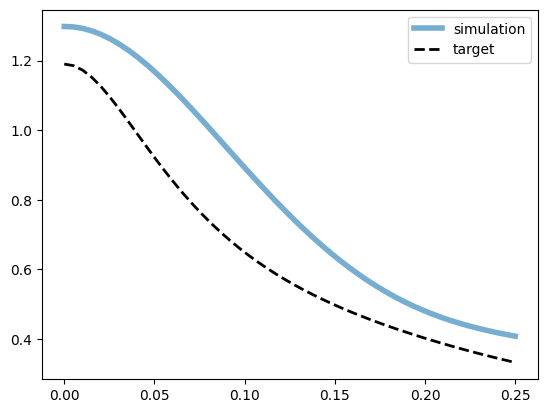

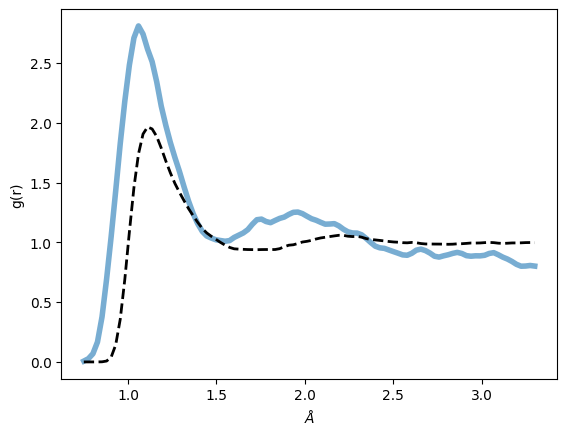

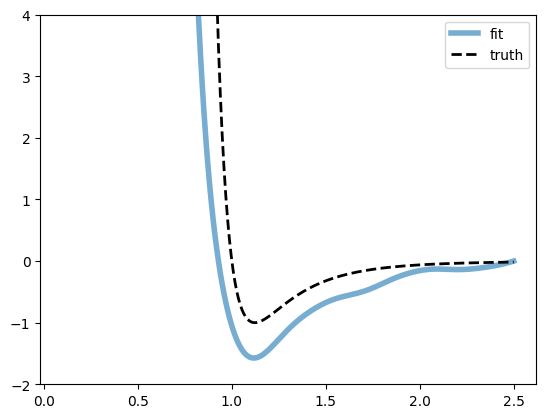

0.03028431162238121 0.15798920392990112
0.014444563537836075 0.17747701704502106
0.01717984490096569 0.18406343460083008
0.01147444173693657 0.12938453257083893
0.013276176527142525 0.08416710048913956


In [21]:
for i in range(n_epochs):

    loss_rdf = torch.Tensor([0.0]).to(device)
    loss_vacf = torch.Tensor([0.0]).to(device)

    n_train = len(data_str_list)
    
    for j, sim in enumerate(sim_list[:n_train]): 
        data_str = (data_str_list + val_str_list)[j]
        # get dt 
        dt = 0.005 
        
        # Simulate 
        v_t, q_t, pv_t = sim.simulate(steps=tau, frequency=tau, dt=dt)
        
        if data_str in val_str_list:
            v_t = v_t.detach()
            q_t = q_t.detach()
            pv_t = pv_t.detach()

        if torch.isnan(q_t.reshape(-1)).sum().item() > 0:
            print("encounter NaN")
            print( 5 - (i / n_epochs) * 5 )
            break
        #_, _, g_sim = rdf_obs_list[j](q_t[::skip])
        # save memory by computing it in serial
        skip = 5
        n_frames = q_t[::skip].shape[0] 
        for idx in range(n_frames):
            if idx == 0:
                _, _, g_sim = rdf_obs_list[j](q_t[::skip][[idx]])
            else:
                g_sim += rdf_obs_list[j](q_t[::skip][[idx]])[2]

        g_sim = g_sim / n_frames

        # compute vacf 
        vacf_sim = vacf_obs_list[j](v_t)

        if data_str in data_str_list:
            if vacf_target_list[j] is not None:
                loss_vacf += (vacf_sim - vacf_target_list[j][:t_range]).pow(2).mean()
            else:
                loss_vacf += 0.0

            drdf = g_sim - rdf_target_list[j]
            loss_rdf += (drdf).pow(2).mean()#+ JS_rdf(g_sim, rdf_target_list[j])

        obs_log[data_str]['rdf'].append(g_sim.detach().cpu().numpy())
        obs_log[data_str]['vacf'].append(vacf_sim.detach().cpu().numpy())

        if i % 5 ==0 :
            if vacf_target_list[j] is not None:
                vacf_target = vacf_target_list[j][:t_range].detach().cpu().numpy()
            else:
                vacf_target = None
            rdf_target = rdf_target_list[j].detach().cpu().numpy()

            plot_vacf(vacf_sim.detach().cpu().numpy(), vacf_target, 
                fn=data_str + "_{}".format(str(i).zfill(3)), 
                dt=dt,
                path=model_path)

            plot_rdf(g_sim.detach().cpu().numpy(), rdf_target, 
                fn=data_str + "_{}".format(str(i).zfill(3)),
                    path=model_path, 
                    start=rdf_start, 
                    nbins=nbins,
                    end=rdf_obs_list[j].r_axis[-1])

        if i % 5 ==0 :
            potential = plot_pair( path=model_path,
                            fn=str(i).zfill(3),
                            model=sim.integrator.model.models['pairnn'].model, 
                            prior=sim.integrator.model.models['pair'].model, 
                            device=device,
                            target_pot=target_pot.to(device),
                            end=cutoff)

    if train_vacf == "True":
        loss = rdf_weight * loss_rdf +  vacf_weight * loss_vacf
    else:
        loss = rdf_weight * loss_rdf

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    
    print(loss_vacf.item(), loss_rdf.item())
    
    scheduler.step(loss)
    
    loss_log.append([loss_vacf.item(), loss_rdf.item() ])

    current_lr = optimizer.param_groups[0]["lr"]

    if current_lr <= 1e-5:
        print("training converged")
        break

    np.savetxt(model_path + '/loss.txt', np.array(loss_log), delimiter=',')

# # save potentials         
# if np.array(loss_log)[-10:, 1].mean() <=  0.005: 
#     np.savetxt(model_path + '/potential.txt',  potential, delimiter=',')


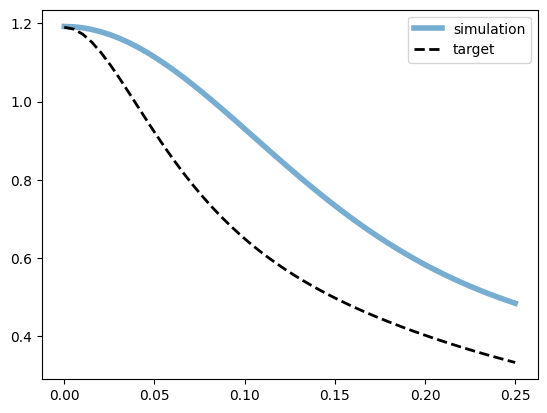

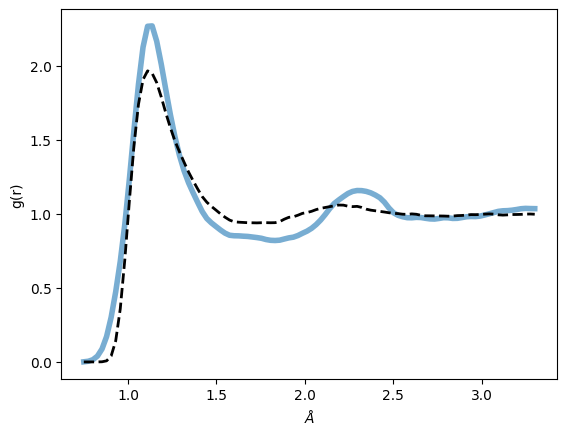

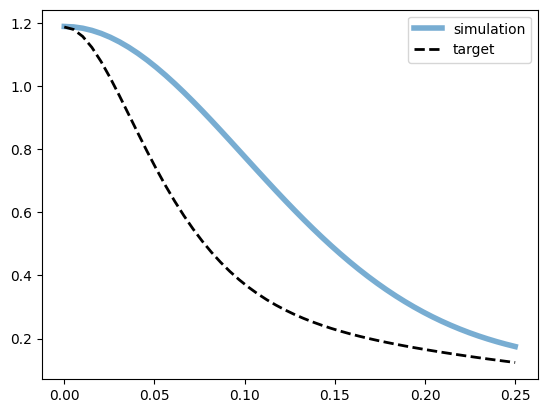

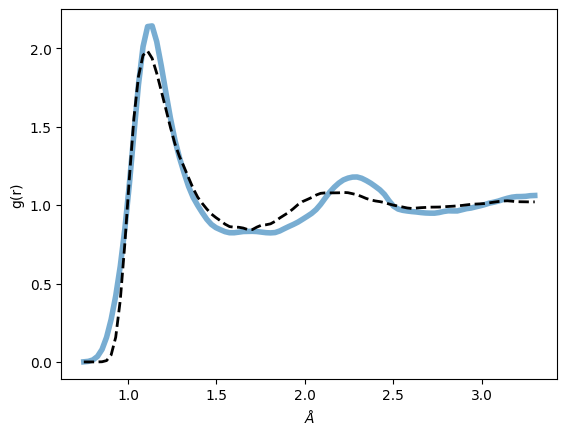

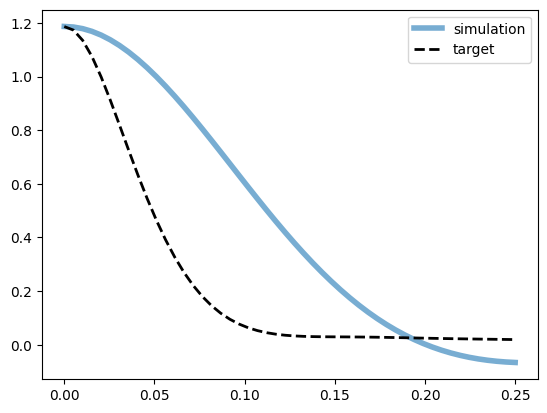

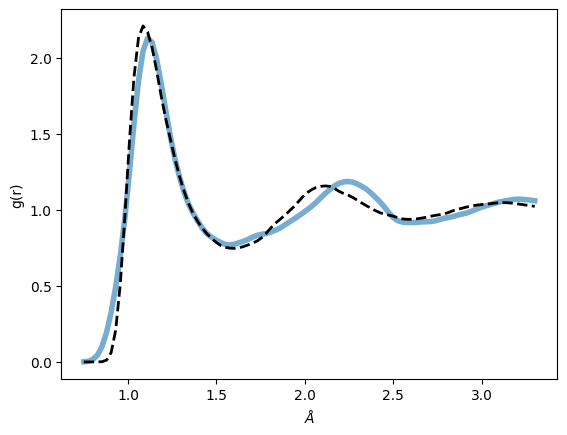

In [22]:

# # save potentials         
# if np.array(loss_log)[-10:, 1].mean() <=  0.005: 
#     np.savetxt(model_path + '/potential.txt',  potential, delimiter=',')

rdf_dev = []

for j, sim in enumerate(sim_list):

    #simulate with no optimization
    data_str = (data_str_list + val_str_list)[j]

    dt = 0.005

    all_vacf_sim = []

    for i in range(n_sim):
        v_t, q_t, pv_t = sim.simulate(steps=tau, frequency=tau, dt=dt)

        # compute VACF 
        vacf_sim = vacf_obs_list[j](v_t).detach().cpu().numpy()
        all_vacf_sim.append(vacf_sim)

    all_vacf_sim = np.array(all_vacf_sim).mean(0)
    
    trajs = torch.Tensor( np.stack( sim.log['positions'])).to(system.device).detach()

    # get targets
    if vacf_target_list[j] is not None:
        vacf_target = vacf_target_list[j][:t_range].detach().cpu().numpy()
    else:
        vacf_target = None
    rdf_target = rdf_target_list[j].detach().cpu().numpy()
    

    # loop over to ocmpute observables 
    all_g_sim = []
    for i in range(len(trajs)):
        _, _, g_sim = rdf_obs_list[j](trajs[[i]])
        all_g_sim.append(g_sim.detach().cpu().numpy())

    all_g_sim = np.array(all_g_sim).mean(0)
    
    # compute target deviation 
    if data_str in data_str_list:
        drdf = np.abs(all_g_sim - rdf_target_list[j].cpu().numpy()).mean()
        rdf_dev.append(drdf) 

    # plot observables 
    plot_vacf(all_vacf_sim, vacf_target, 
        fn=data_str, 
        path=model_path,
        dt=dt,
        save_data=True)

    plot_rdf(all_g_sim, rdf_target, 
        fn=data_str,
            path=model_path, 
            start=rdf_start, 
            nbins=nbins,
            save_data=True,
            end=rdf_obs_list[j].r_axis[-1])


    # rdf_dev = np.abs(all_g_sim - rdf_target).mean()



## Evaluation

with save traj

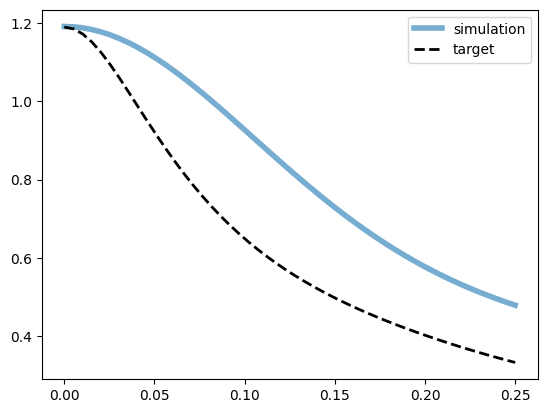

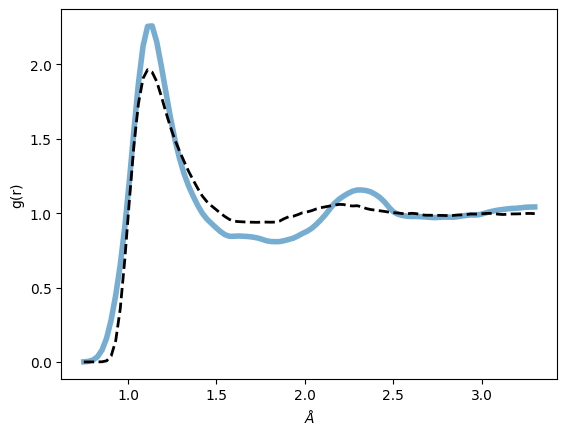

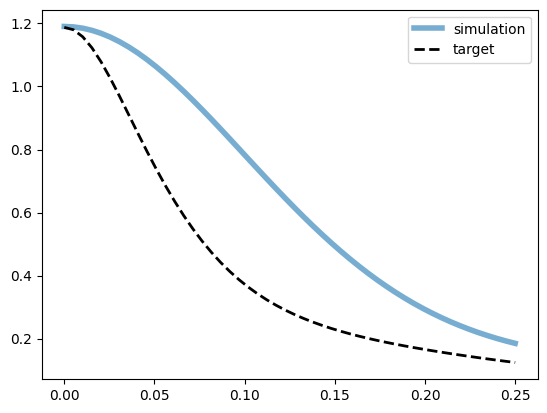

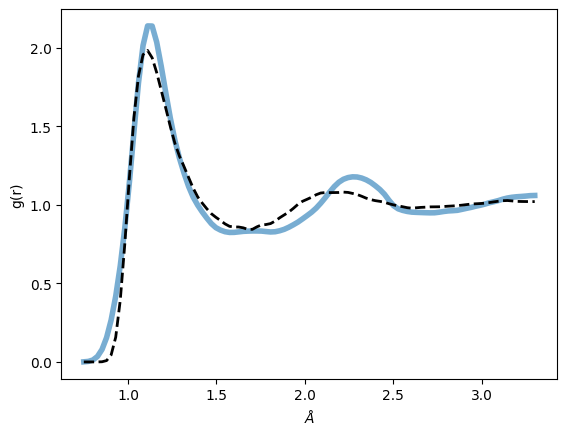

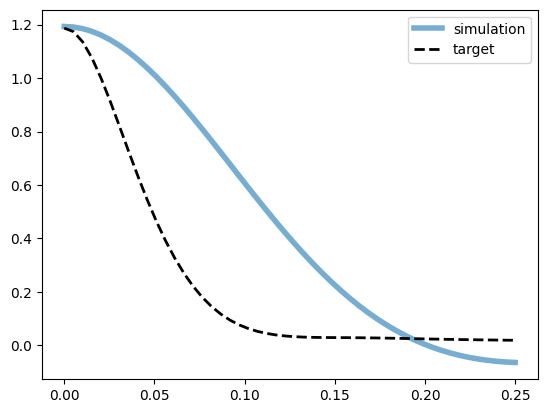

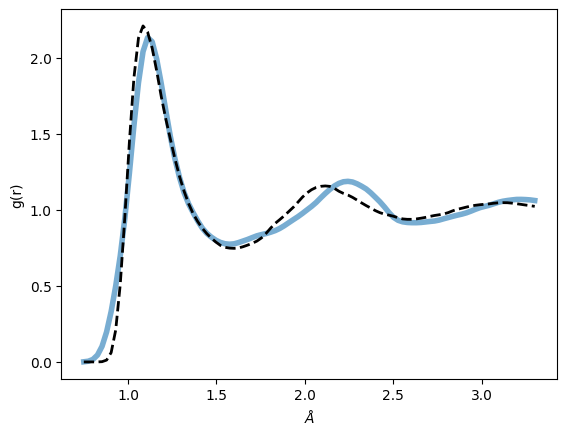

In [23]:
# Save the learned potential if the final RDF loss is below threshold
if np.array(loss_log)[-10:, 1].mean() <= 0.005: 
    potential = plot_pair(path=model_path,
                          fn="final",
                          model=sim.integrator.model.models['pairnn'].model, 
                          prior=sim.integrator.model.models['pair'].model, 
                          device=device,
                          target_pot=target_pot.to(device),
                          end=cutoff)
    
    np.savetxt(model_path + '/potential.txt', potential, delimiter=',')

rdf_dev = []
import ase
import ase.io

# Function to save trajectory as XYZ file
def save_traj(system, traj, fname, skip=10):
    """
    Saves atomic trajectories as an XYZ file for visualization.

    Parameters:
        system: ASE Atoms object representing the molecular system.
        traj: List of atomic positions at different timesteps.
        fname: Filename for saving the trajectory.
        skip: Interval for saving frames (reduces file size).
    """
    atoms_list = []
    for i, frame in enumerate(traj):
        if i % skip == 0:  # Save every 'skip' frames to reduce file size
            frame = ase.Atoms(positions=frame, numbers=system.get_atomic_numbers())
            atoms_list.append(frame)
    ase.io.write(fname, atoms_list)  # Save as XYZ file

# Final evaluation loop
for j, sim in enumerate(sim_list):

    # Simulate with the trained model (without optimization)
    data_str = (data_str_list + val_str_list)[j]
    train_traj = sim.log['positions']

    # Save training trajectory
    save_traj(system_list[j], train_traj, model_path + '/{}_train.xyz'.format(data_str), skip=10)

    dt = 0.005
    all_vacf_sim = []

    for i in range(n_sim):
        v_t, q_t, pv_t = sim.simulate(steps=tau, frequency=tau, dt=dt)

        # Compute VACF
        vacf_sim = vacf_obs_list[j](v_t).detach().cpu().numpy()
        all_vacf_sim.append(vacf_sim)

    all_vacf_sim = np.array(all_vacf_sim).mean(0)
    
    trajs = torch.Tensor(np.stack(sim.log['positions'])).to(system.device).detach()

    # Get target RDF and VACF
    if vacf_target_list[j] is not None:
        vacf_target = vacf_target_list[j][:t_range].detach().cpu().numpy()
    else:
        vacf_target = None
    rdf_target = rdf_target_list[j].detach().cpu().numpy()
    
    # Compute RDF over all saved trajectories
    all_g_sim = []
    for i in range(len(trajs)):
        _, _, g_sim = rdf_obs_list[j](trajs[[i]])
        all_g_sim.append(g_sim.detach().cpu().numpy())

    all_g_sim = np.array(all_g_sim).mean(0)
    
    # Compute target deviation
    if data_str in data_str_list:
        drdf = np.abs(all_g_sim - rdf_target_list[j].cpu().numpy()).mean()
        rdf_dev.append(drdf) 

    # Plot and save observables (VACF and RDF)
    plot_vacf(all_vacf_sim, vacf_target, 
              fn=data_str, 
              path=model_path,
              dt=dt,
              save_data=True)

    plot_rdf(all_g_sim, rdf_target, 
             fn=data_str,
             path=model_path, 
             start=rdf_start, 
             nbins=nbins,
             save_data=True,
             end=rdf_obs_list[j].r_axis[-1])

    # Save final trajectory (inference trajectory)
    save_traj(system_list[j], np.stack(sim.log['positions']),  
              model_path + '/{}_sim.xyz'.format(data_str), skip=1)


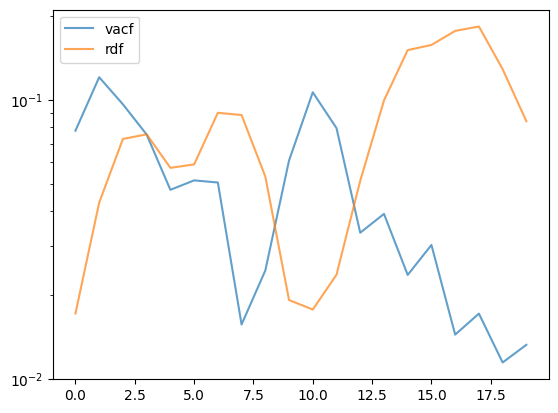

0.10773258581757546


2025-01-30 20:42:19.467 python[1534:4444618] +[IMKClient subclass]: chose IMKClient_Legacy
2025-01-30 20:42:19.467 python[1534:4444618] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [24]:
np.savetxt(model_path + '/potential.txt',  potential, delimiter=',')
np.savetxt(model_path + '/rdf_dev.txt', np.array(rdf_dev), delimiter=',')


# save loss curve 
plt.plot(np.array( loss_log)[:, 0], label='vacf', alpha=0.7)
plt.plot(np.array( loss_log)[:, 1], label='rdf', alpha=0.7)
plt.yscale("log")
plt.legend()

plt.savefig(model_path + '/loss.pdf', bbox_inches='tight')
plt.show()
plt.close()

print( np.array(loss_log)[-10:, 1].mean()  )

